## Regresión Avanzada

## Clase 5

In [1]:
suppressMessages( library( gamlss ) )
suppressMessages( library( tidyverse ) )
suppressMessages( library( ggpubr ) )
suppressMessages( library( skimr ) )
suppressMessages( library( readxl ) )
suppressMessages( library( ResourceSelection ) )
suppressMessages( library( pROC ) )

## 1. Modelos GAM

### Ejemplo Alquiler: Las variables

* **R**: precio del alquiler.

* **Fl**: metros cuadrados de la vivienda.

* **A**: año de construcción.

* **Sp**: calidad del barrio de la vivienda superior la media (1) o no (0).

* **Sm**: si la calidad del barrio donde está situada la vivienda es inferior la media (1) o no (0).

* **B**: si tiene cuarto de baño (1) o no (0).

* **H**: si tiene calefacción central (1) o no (0).

* **L**: equipamiento de la cocina por encima de la media (1) o no (0).

* **loc**: combinación de Sp y Sm indicando si la calidad del barrio donde está situada la vivienda es inferior (1), igual (2) o superior (3) a la media.

In [2]:
data( 'rent' )
datos <- rent %>% select( R, Fl, A, H, loc )
datos <- datos %>% setNames( c( 'valor', 'metros', 'anio', 'calef', 'local' ) )

### Exploración de Datos

### Modelo OLS

In [3]:
mod_OLS <- gamlss( valor ~ metros + anio + calef + local, family = NO, data = datos, trace = FALSE )
summary( mod_OLS )

******************************************************************
Family:  c("NO", "Normal") 

Call:  gamlss(formula = valor ~ metros + anio + calef + local,  
    family = NO, data = datos, trace = FALSE) 

Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  identity
Mu Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2775.0388   470.1352  -5.903 4.20e-09 ***
metros          8.8394     0.3370  26.228  < 2e-16 ***
anio            1.4808     0.2385   6.208 6.55e-10 ***
calef1       -204.7596    18.9858 -10.785  < 2e-16 ***
local2        134.0523    25.1430   5.332 1.09e-07 ***
local3        209.5815    27.1286   7.725 1.76e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

------------------------------------------------------------------
Sigma link function:  log
Sigma Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.73165    0.01594   359

### Diagnóstico

******************************************************************
	      Summary of the Quantile Residuals
                           mean   =  4.959554e-13 
                       variance   =  1.000508 
               coef. of skewness  =  0.7470097 
               coef. of kurtosis  =  4.844416 
Filliben correlation coefficient  =  0.9859819 
******************************************************************


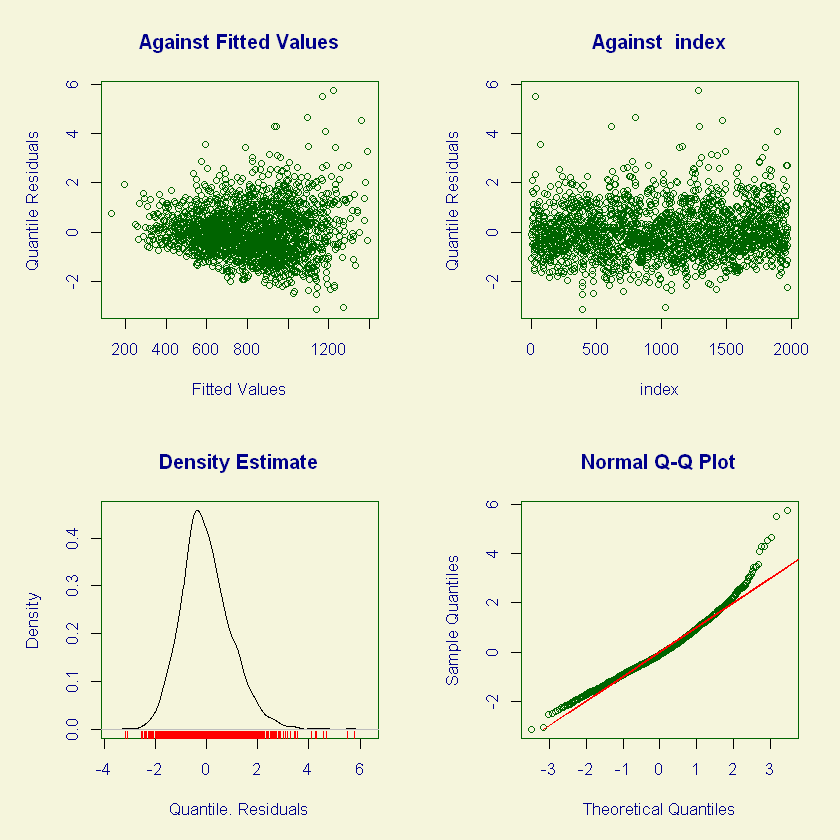

In [4]:
plot( mod_OLS )

### Gráficos worm

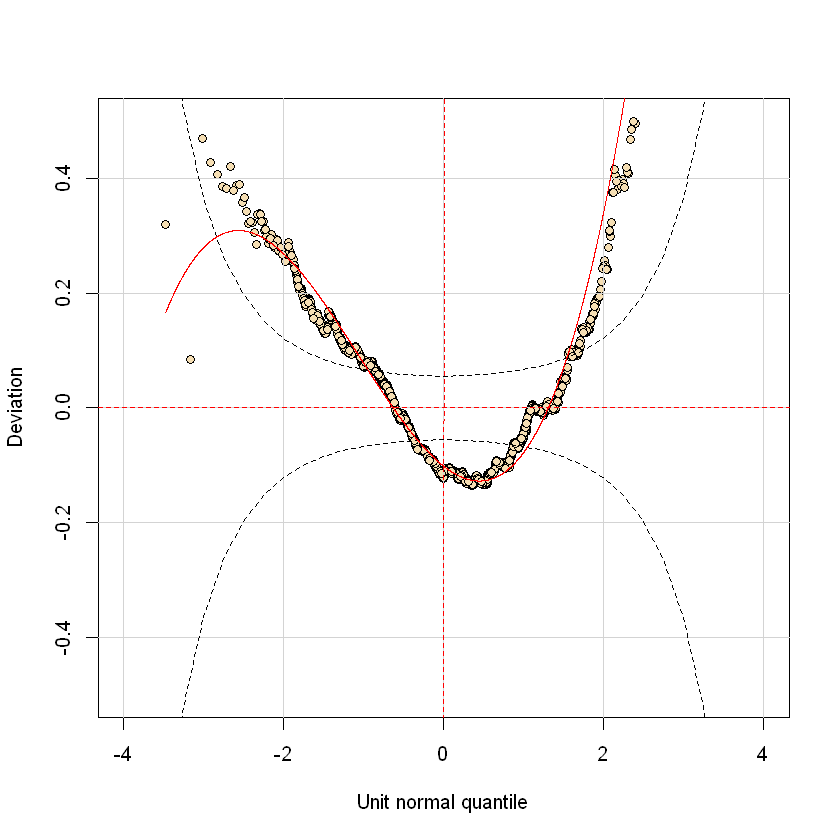

In [5]:
suppressWarnings( wp( mod_OLS, ylim.all = 0.5 ) )

La varianza de los errores aumenta con la media, la normalidad no se satisface, por lo cual el OLS no parece un modelo adecuado para este caso.

Estos modelos permiten aplicar funciones (lineales o no lineales) a cada uno de los predictores. El paquete gamlss provee varias alternativas de suavizado que suelen dar buenos resultados. Vamos a usar para este caso P-splines ( pb() ). Sólo tiene sentido aplicar este suavizado para variables continuas.

### Modelo GAM

In [6]:
mod_GAM <- gamlss( formula = valor ~ pb( metros ) + pb( anio ) + calef + local, family = GA, data = datos, trace = FALSE )

### Salida GAM

In [7]:
summary( mod_GAM )

******************************************************************
Family:  c("GA", "Gamma") 

Call:  gamlss(formula = valor ~ pb(metros) + pb(anio) + calef +  
    local, family = GA, data = datos, trace = FALSE) 

Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  log
Mu Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.0851197  0.5692315   5.420 6.70e-08 ***
pb(metros)   0.0103084  0.0004031  25.573  < 2e-16 ***
pb(anio)     0.0014062  0.0002893   4.861 1.26e-06 ***
calef1      -0.3008111  0.0225869 -13.318  < 2e-16 ***
local2       0.1886692  0.0299295   6.304 3.58e-10 ***
local3       0.2719856  0.0322862   8.424  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

------------------------------------------------------------------
Sigma link function:  log
Sigma Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.00196    0.01559  -6

### Análisis Diagnóstico GAM

******************************************************************
	      Summary of the Quantile Residuals
                           mean   =  0.0005312226 
                       variance   =  1.00067 
               coef. of skewness  =  -0.1235641 
               coef. of kurtosis  =  3.322109 
Filliben correlation coefficient  =  0.9989678 
******************************************************************


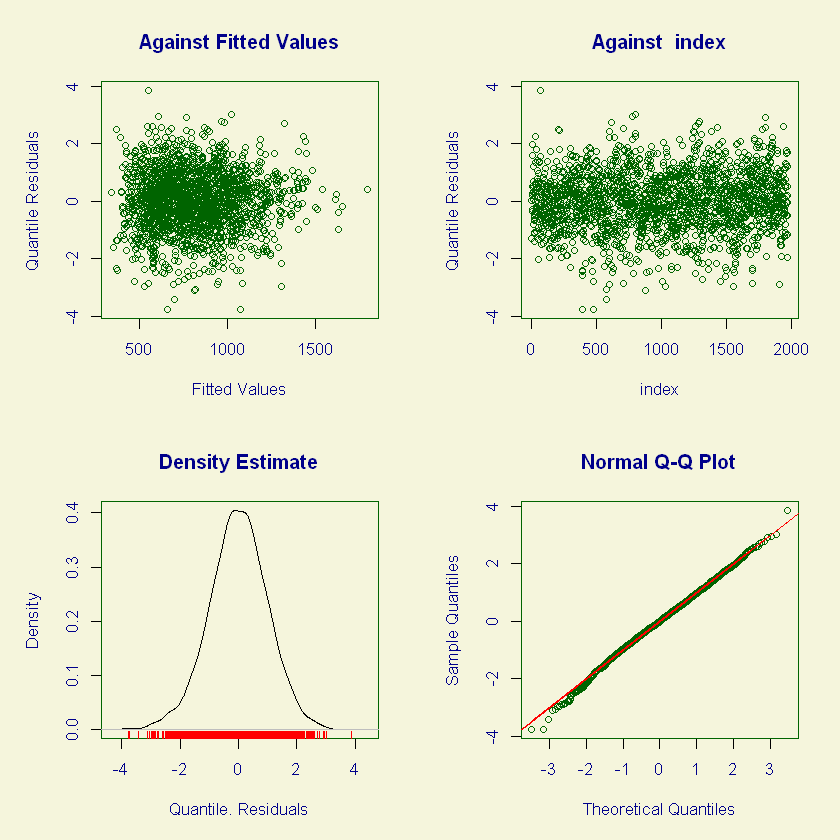

In [8]:
plot( mod_GAM )

### Gráfico worm GAM

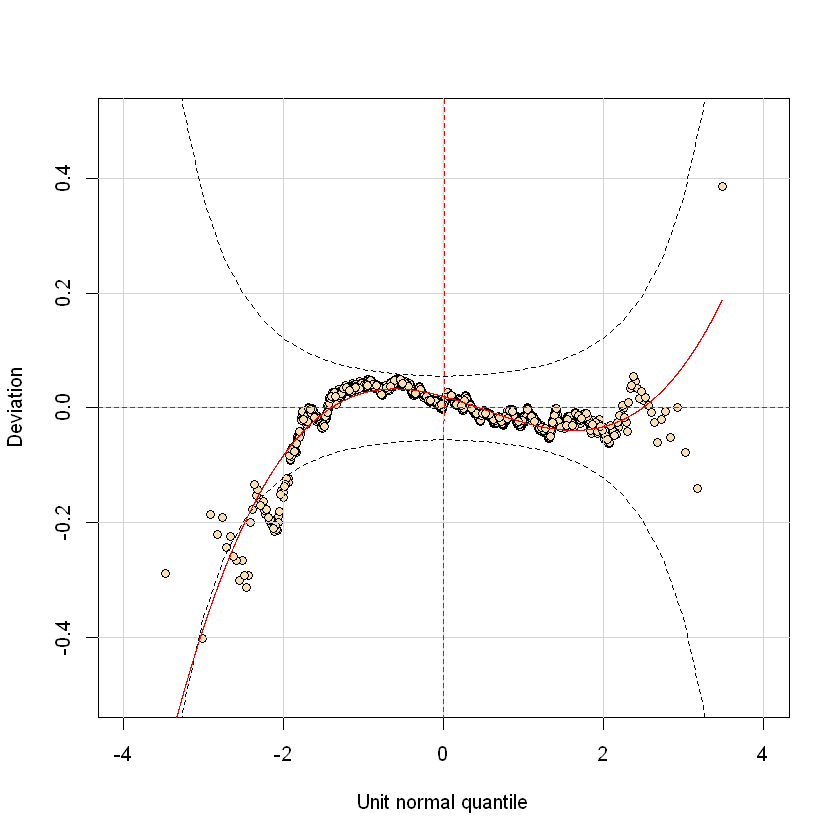

In [9]:
suppressWarnings( wp( mod_GAM, ylim.all = 0.5 ) )

### Interpretación del Modelo GAM

Los errores de este modelo sólo contemplan la parte lineal, no las funciones suavizadas(smooth: metros y anio); es decir que los errores asumen que las funciones smooth son fijas y no consideran la variabilidad introducida por ellas. Existe sin embargo un cálculo de AIC y significacion estadística de
los predictores (todos!) que se plantea cuánto se pierde al eliminar secuencialmente a cada una de las variables del modelo. (drop1())

### Significación Estadística de los predictores (GAM)

In [10]:
print( drop1( mod_GAM, parallel = 'multicore', ncpus = 4 ) )

Single term deletions for
mu

Model:
valor ~ pb(metros) + pb(anio) + calef + local
               Df   AIC    LRT   Pr(Chi)    
<none>            27706                     
pb(metros) 1.4680 28261 558.59 < 2.2e-16 ***
pb(anio)   4.3149 27798 101.14 < 2.2e-16 ***
calef      1.8445 27862 160.39 < 2.2e-16 ***
local      2.0346 27770  68.02 1.825e-15 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Al añadir términos no lineales en un modelo, se complejiza su interpretabilidad, sin embargo puede ilustrase el efecto de cada predictor.(term.plot())

### Efectos individuales de los predictores (GAM)

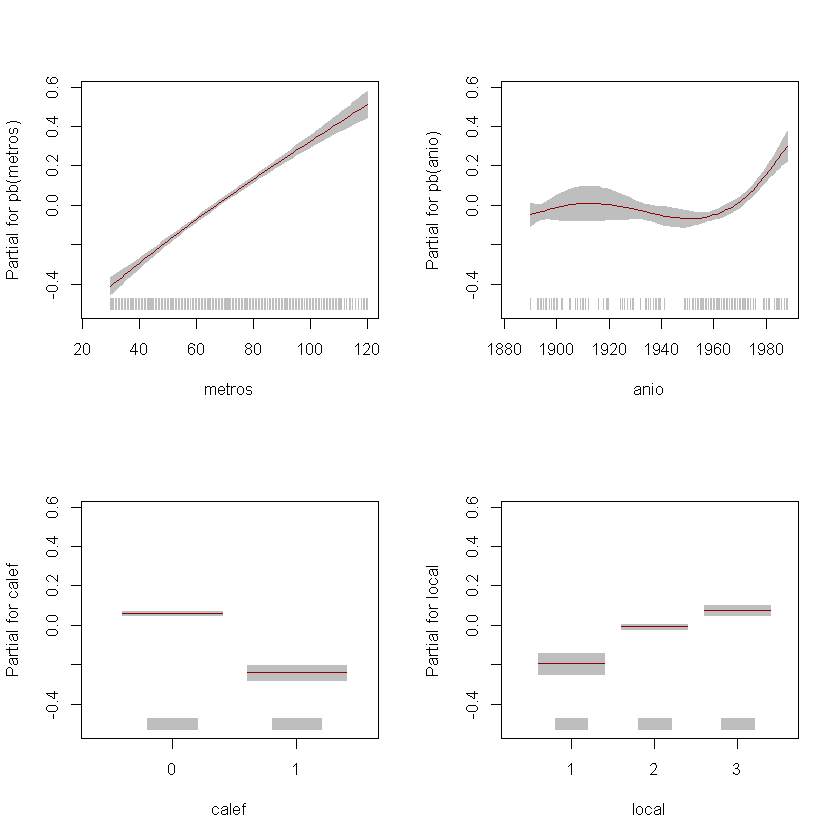

In [11]:
term.plot( mod_GAM, , pages = 1, ask = FALSE, rug = TRUE )

### Interpretacióon de los Efectos

Estas gr´aficas representan la relaci´on entre η = log (μ) con cada uno de los predictores:

* El efecto de la superficie es lineal con el valor de la vivienda, al menos en el rango estudiado.

* El efecto del año de construcción de la misma no se aprecia lineal, aumenta a partir de 1960 aproximadamente; antes de ello parece constante.

* La localización en un buen vecindario eleva el valor del alquiler.

* La calefacción (central?) disminuye el valor del alquiler.

## 2. Modelos GAMLSS

### El ajuste ( GAMLSS )

In [12]:
mod_GAMLSS <- gamlss( formula = valor ~ pb( metros ) + pb( anio ) + calef + local, 
    sigma.formula = ~ pb( metros ) + pb( anio ) + calef + local, 
    family = GA, 
    data = datos, 
    trace = FALSE )

summary( mod_GAMLSS )

******************************************************************
Family:  c("GA", "Gamma") 

Call:  gamlss(formula = valor ~ pb(metros) + pb(anio) + calef +  
    local, sigma.formula = ~pb(metros) + pb(anio) +  
    calef + local, family = GA, data = datos, trace = FALSE) 

Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  log
Mu Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.8844571  0.5823154   4.953 7.92e-07 ***
pb(metros)   0.0105402  0.0003620  29.117  < 2e-16 ***
pb(anio)     0.0014977  0.0002955   5.068 4.40e-07 ***
calef1      -0.2918923  0.0242789 -12.022  < 2e-16 ***
local2       0.1938688  0.0323320   5.996 2.40e-09 ***
local3       0.2734326  0.0339177   8.062 1.30e-15 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

------------------------------------------------------------------
Sigma link function:  log
Sigma Coefficients:
              Estimate Std

### Efecto individuales de los Predictores (GAMLSS)

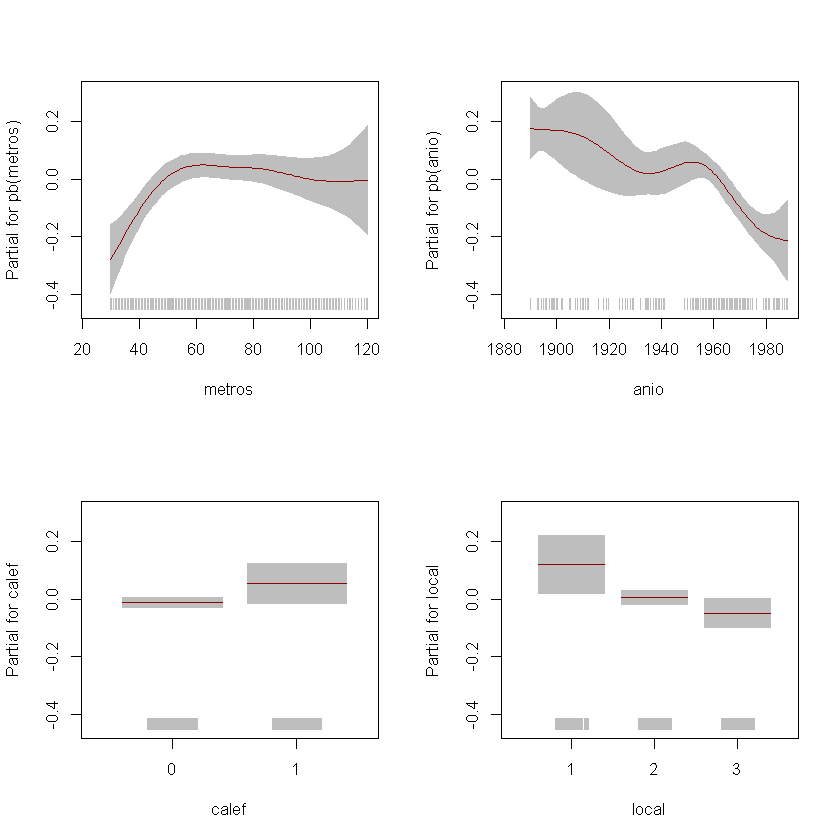

In [37]:
term.plot( mod_GAMLSS, pages = 1, parameter = 'sigma', ask = FALSE, rug = TRUE )

### Contribución de cada uno de los predictores (GAMLSS)

In [38]:
print( drop1( mod_GAMLSS, parameter = 'sigma', parallel = 'multicore', ncpus = 4 ) )

Single term deletions for
sigma

Model:
~pb(metros) + pb(anio) + calef + local
                Df   AIC    LRT   Pr(Chi)    
<none>             27615                     
pb(metros) 4.02694 27631 24.683 5.997e-05 ***
pb(anio)   3.87807 27659 52.167 1.067e-10 ***
calef      0.88335 27615  1.866   0.14788    
local      2.03694 27619  8.036   0.01872 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


### Reformulación modelos GAMLSS(1)

Del gráfico y la salida del drop surge que debería eliminarse el predictor calefacción de la estimación del parámetro σ, dado que no es significativo.

In [39]:
mod_GAMLSS1 <- gamlss( formula = valor ~ pb( metros ) + pb( anio ) + calef + local,
    sigma.formula = ~ pb( metros ) + pb( anio ) + local, 
    family = GA, 
    data = datos, 
    trace = FALSE )

### Estimación de los efectos para μ

In [40]:
summary( mod_GAMLSS1 )

******************************************************************
Family:  c("GA", "Gamma") 

Call:  gamlss(formula = valor ~ pb(metros) + pb(anio) + calef +  
    local, sigma.formula = ~pb(metros) + pb(anio) +  
    local, family = GA, data = datos, trace = FALSE) 

Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  log
Mu Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.8250073  0.5847580   4.831 1.46e-06 ***
pb(metros)   0.0105520  0.0003620  29.147  < 2e-16 ***
pb(anio)     0.0015267  0.0002968   5.145 2.95e-07 ***
calef1      -0.2905070  0.0235304 -12.346  < 2e-16 ***
local2       0.1957823  0.0322755   6.066 1.57e-09 ***
local3       0.2753056  0.0338782   8.126 7.78e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

------------------------------------------------------------------
Sigma link function:  log
Sigma Coefficients:
              Estimate Std. Error 

### Estimación de los efectos para σ (GAMLSS1)

### Efecto individual de los predictores (GAMLSS1)

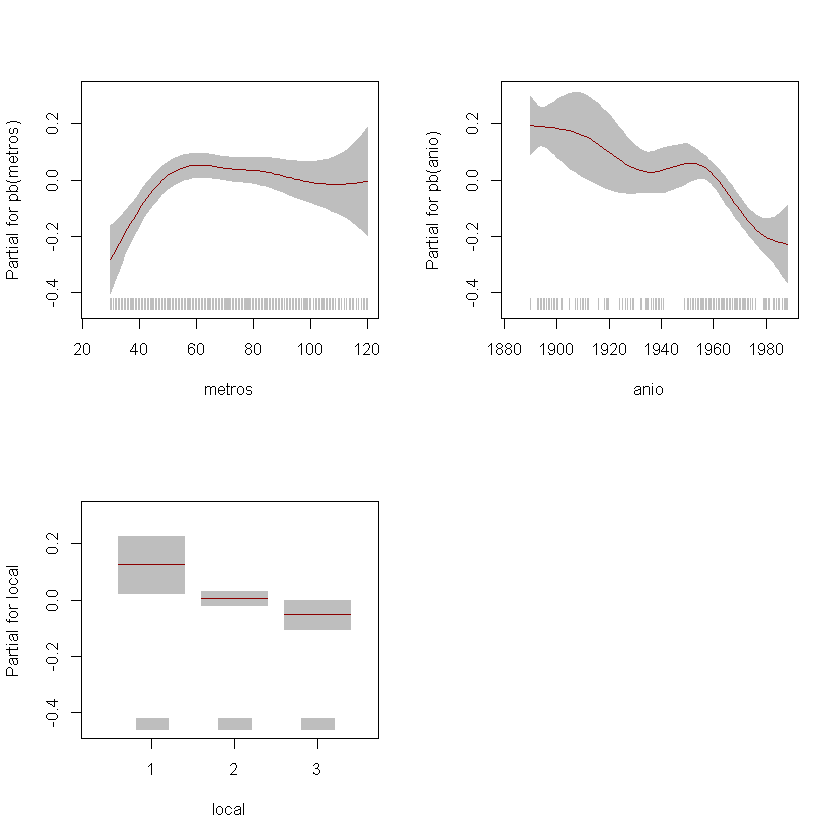

In [41]:
term.plot( mod_GAMLSS1, pages = 1, parameter = 'sigma', ask = FALSE, rug = TRUE )

### Contribución individual de las variables

In [42]:
print( drop1( mod_GAMLSS1, parameter = 'sigma', parallel = 'multicore', ncpus = 4) )

Single term deletions for
sigma

Model:
~pb(metros) + pb(anio) + local
               Df   AIC    LRT   Pr(Chi)    
<none>            27615                     
pb(metros) 4.0566 27632 24.763 5.968e-05 ***
pb(anio)   3.4102 27672 63.780 1.824e-13 ***
local      2.0086 27620  8.765   0.01262 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


### Worm plot de los residuos

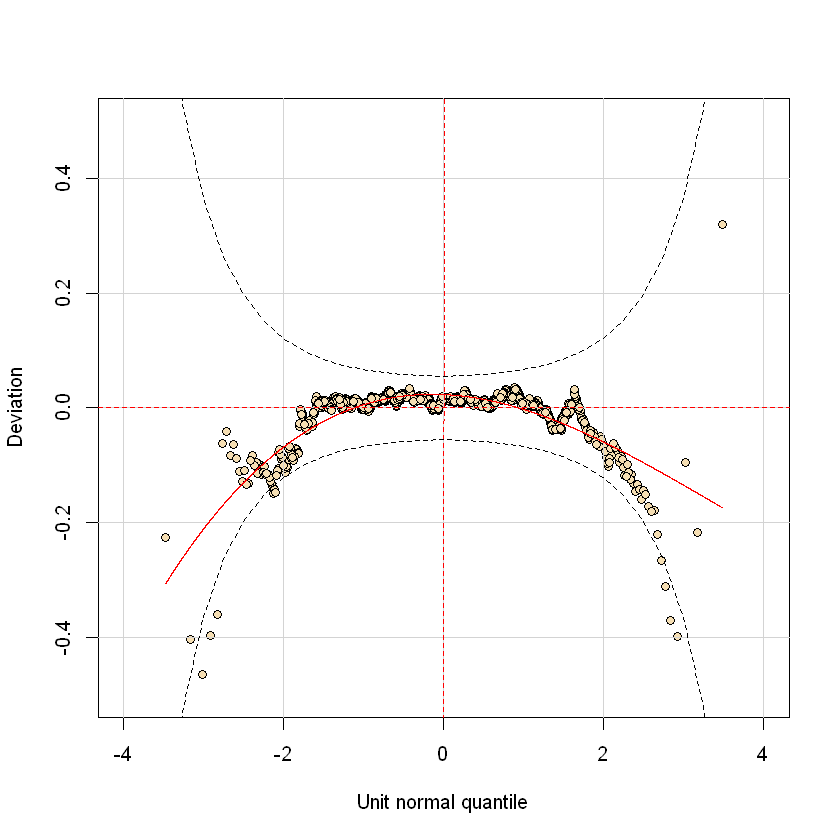

In [43]:
suppressWarnings( wp( mod_GAMLSS1, ylim.all = 0.5 ) )

### Observaciones

La inspección visual del wormplot indica que este modelo tiene los residuos dentro del rango de variación aceptable, sin embargo se aprecia una estructura de U invertida. Esto puede deberse a que el modelo no logre captar bien la asimetría de la distribución de los valores.

### Comparación de los Modelos

In [44]:
#Comparamos los modelos ajustados:
print( GAIC( mod_OLS, mod_GAMLSS1, mod_GAM ) )

                  df      AIC
mod_GAMLSS1 21.36701 27614.88
mod_GAM     11.21547 27705.65
mod_OLS      7.00000 28173.00


De acuerdo con el criterio GAIC, el modelo GAMLSS es el que mejor explica la relación con el valor utilizando los mismos predictores.

## 3. Modelos Lineales Generalizados

### Ejemplo Poisson

Se está conduciendo un experimento que se propone analizar el daño causado en las embarcaciones debido a la exposición al oleaje. Como parte del proyecto se recolectaron los siguientes datos:

* **type**: tipo de embarcación (codificado con las letra A - E)

* **year**: año de construcción de la embarcación

* **period**: periodo de operación (1960-74, 75-79)

* **service**: acumulado de meses en servicio

* **incidents**: número de incidentes por daño

### Ajuste de primer modelo

Acá utilizamos todas las variables disponibles en la base.

In [45]:
# Utilizamos los datos ships de la biblioteca MASS
data( ships )

datos_ships <- ships %>% filter( service != 0 )

# Eliminamos los registros que no tuvieron servicios
fit <- glm( incidents ~ ., datos_ships, family = "poisson" )

summary( fit )


Call:
glm(formula = incidents ~ ., family = "poisson", data = datos_ships)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4598  -1.6558  -0.3323   0.6261   3.5104  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.387e+00  1.151e+00  -3.811 0.000138 ***
typeB        9.622e-01  2.058e-01   4.675 2.94e-06 ***
typeC       -1.212e+00  3.274e-01  -3.701 0.000215 ***
typeD       -8.652e-01  2.875e-01  -3.009 0.002619 ** 
typeE       -1.105e-01  2.350e-01  -0.470 0.638160    
year         5.280e-02  1.378e-02   3.831 0.000127 ***
period       3.642e-02  9.245e-03   3.939 8.19e-05 ***
service      4.785e-05  7.050e-06   6.787 1.15e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 614.54  on 33  degrees of freedom
Residual deviance: 120.56  on 26  degrees of freedom
AIC: 234.43

Number of Fisher Scoring iterations: 5


### Bondad de Ajuste

In [46]:
# Podemos pedir solamente los coeficientes del modelo
print( coef( fit ) )

# Comparamos la deviance del modelo con la del modelo nulo, para ver si es signficativo
dev <- fit$deviance
nullDev <- fit$null.deviance
modelChi <- nullDev - dev

# Calculamos la diferencia de deviances
print( modelChi )

# Calculamos los grados de libertad de la diferencia
chidf <- fit$df.null - fit$df.residual 
chisq.prob <- 1 - pchisq( modelChi, chidf )

print( chisq.prob )

  (Intercept)         typeB         typeC         typeD         typeE 
-4.387119e+00  9.621783e-01 -1.211745e+00 -8.651758e-01 -1.105281e-01 
         year        period       service 
 5.280368e-02  3.641570e-02  4.785082e-05 
[1] 493.9752
[1] 0


Nuestro modelo es estadísticamente significativo. Además en comparacióon con un barco tipo A, los tipo B sufren más incidentes dado que el coeficiente es positivo, y además también a comparación de los tipo A, los barcos tipo E, D y C son sufren menos incidentes, siendo 'más seguros' los del tipo C. También notamos que conforme aumentan el año de construcción, los barcos tienen menos incidentes. Finalmente vemos que durante el primer periodo de operación se sufren menos incidentes que en el segundo, es decir, si el periodo de operación es más reciente, más incidentes tendrá.

### Selección de Modelos por AIC

In [47]:
summary( stepAIC( fit ) )

Start:  AIC=234.43
incidents ~ type + year + period + service

          Df Deviance    AIC
<none>         120.56 234.43
- year     1   135.85 247.72
- period   1   137.28 249.15
- service  1   167.80 279.67
- type     4   208.01 313.88



Call:
glm(formula = incidents ~ type + year + period + service, family = "poisson", 
    data = datos_ships)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4598  -1.6558  -0.3323   0.6261   3.5104  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.387e+00  1.151e+00  -3.811 0.000138 ***
typeB        9.622e-01  2.058e-01   4.675 2.94e-06 ***
typeC       -1.212e+00  3.274e-01  -3.701 0.000215 ***
typeD       -8.652e-01  2.875e-01  -3.009 0.002619 ** 
typeE       -1.105e-01  2.350e-01  -0.470 0.638160    
year         5.280e-02  1.378e-02   3.831 0.000127 ***
period       3.642e-02  9.245e-03   3.939 8.19e-05 ***
service      4.785e-05  7.050e-06   6.787 1.15e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 614.54  on 33  degrees of freedom
Residual deviance: 120.56  on 26  degrees of freedom
AIC: 234.43

Number of Fisher Scori

Por último, ajustamos un modelo sugerido:

In [48]:
fit_hint <- glm( incidents ~ offset( log( service ) ) + type + year + period, data = datos_ships, family = "poisson" )
summary( fit_hint )


Call:
glm(formula = incidents ~ offset(log(service)) + type + year + 
    period, family = "poisson", data = datos_ships)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5348  -0.9319  -0.3686   0.4654   2.8833  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -10.079076   0.876149 -11.504  < 2e-16 ***
typeB        -0.546090   0.178415  -3.061 0.002208 ** 
typeC        -0.632631   0.329500  -1.920 0.054862 .  
typeD        -0.232257   0.287979  -0.807 0.419951    
typeE         0.405975   0.234933   1.728 0.083981 .  
year          0.042247   0.012826   3.294 0.000988 ***
period        0.023705   0.008091   2.930 0.003392 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 146.328  on 33  degrees of freedom
Residual deviance:  59.375  on 27  degrees of freedom
AIC: 171.24

Number of Fisher Scoring iterations: 5


El uso de offset() es buena idea pues nos interesa más la tasa ya que no es lo mismo tener 10 incidentes en 3 meses de servicio que tener 10 incidentes en 300 meses de servicio.

## 4. Regresión Logística

## Ejemplo: Diabetes

Corresponden a 145 adultos no obesos que participaron en un estudio para investigar factores asociados a diabetes. Utilizaremos inicialmente la variable SSPG “steady state plasma glucose” (una medida de la resistencia a la insulina) como variable explicativa y como variable respuesta DIABET (DIABET =1 indica que el paciente es diabético). En la tabla de la siguiente diapositiva se aprecia que a medida la proporción de diabéticos aumenta cuando aumenta el valor de la variable explicativa (SSPG).

In [49]:
setwd( "C:/Austral/mcd-reg-adv/datasets" )
diabetes <- read_excel( "diabetes.xls" )

### SSPG y Proporción de Diabéticos

In [50]:
max_sspg <- max(diabetes$SSPG)

breaks <- seq(0, max_sspg, length.out = 11)

group_sspg <- cut(diabetes$SSPG, breaks = breaks, labels = FALSE, include.lowest = TRUE)

mean_sspg <- tapply(diabetes$SSPG, group_sspg, mean)

proportion_diabet <- tapply(diabetes$DIABET, group_sspg, mean)

output_table <- data.frame(
  Grupos = paste0(breaks[-length(breaks)], "-", breaks[-1]),
  Media_SSPG = round(mean_sspg, 2),
  Propor_DIABET = round(proportion_diabet, 2)
)

print(output_table)

    Grupos Media_SSPG Propor_DIABET
1     0-48      38.17          0.00
2    48-96      71.54          0.04
3   96-144     117.93          0.17
4  144-192     163.32          0.42
5  192-240     217.61          0.83
6  240-288     261.71          0.81
7  288-336     310.00          1.00
8  336-384     359.75          1.00
9  384-432     413.00          1.00
10 432-480     457.00          1.00


### Ajuste de la Variable Proporción

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message:
"Removed 16 rows containing missing values (`geom_smooth()`)."


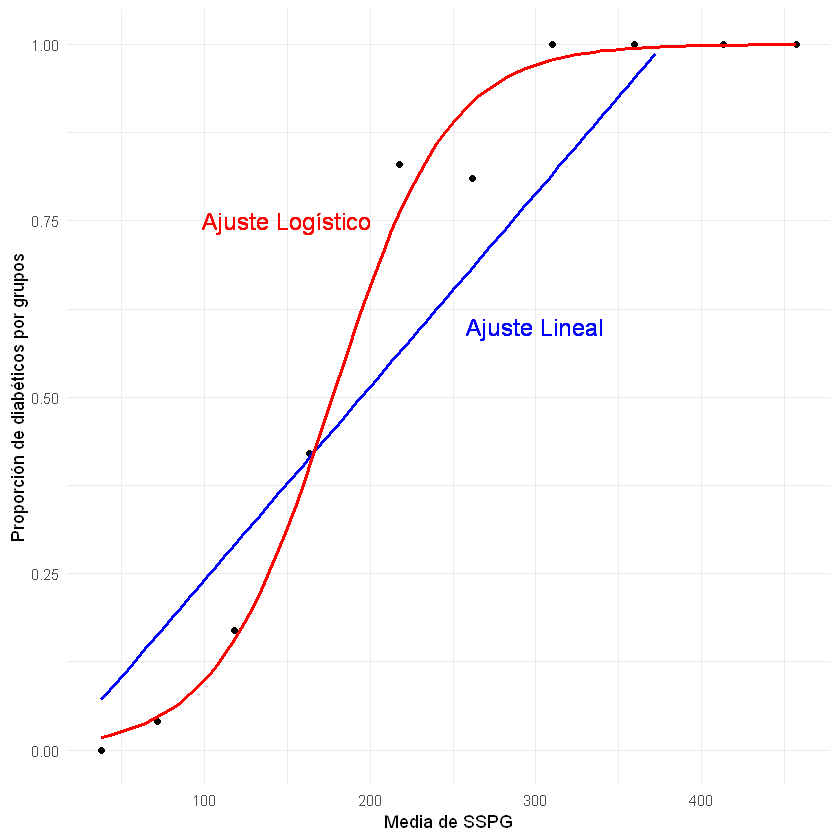

In [57]:
p <- ggplot( output_table, aes( x = Media_SSPG, y = Propor_DIABET ) ) +
        geom_point() +
        geom_smooth( method = "lm", se = FALSE, color = "blue" ) + 
        geom_smooth( method = "glm", se = FALSE, method.args = list( family = "binomial" ), color = "red" ) + 
        labs( x = "Media de SSPG", y = "Proporción de diabéticos por grupos" ) + 
        theme_minimal() +
        ylim( 0, 1 ) +
        geom_text( aes( x = 300, y = 0.6, label = "Ajuste Lineal" ), color = "blue", size = 5 ) +
        geom_text( aes( x = 150, y = 0.75, label = "Ajuste Logístico" ), color = "red", size = 5 )
p

Si ajustamos en forma errónea un modelo de regresión lineal a este conjunto de datos obtendremos la recta ajustada que muestra el diagrama de dispersión de la figura (azul).

## 6. Significado de los Coeficientes del Modelo de Regresión Logística Simple

### Estimación de los Coeficientes del Modelo

La variable respuesta es la presencia ( Y = 1 ) ó ausencia ( Y = 0 ) de diabetes y la única variable explicativa es la SSPG.

In [71]:
mod_1 <- glm( DIABET ~ SSPG, data = diabetes, family = "binomial" )
summary( mod_1 )


Call:
glm(formula = DIABET ~ SSPG, family = "binomial", data = diabetes)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2218  -0.5288  -0.2364   0.4866   2.4856  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.569770   0.712843  -6.411 1.45e-10 ***
SSPG         0.025456   0.003942   6.457 1.07e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 202.15  on 145  degrees of freedom
Residual deviance: 106.98  on 144  degrees of freedom
AIC: 110.98

Number of Fisher Scoring iterations: 6


El modelo estimado de acuerdo con la tabla anterior es:

$$ logit_{(estimado)} = -4,548 + 0,025 * SSPG $$

$$ log_{(odds-est)} = log\left( \frac{p(SSPG)}{1- p(SSPG)} \right) = -4,548 + 0,025 * SSPG $$

La expresión para estimar la probabilidad dado un valor de SSPS es:

$$\widehat{p} = \frac{e^{\left( −4.548 + 0.025∗SSPG \right)}}{1 + e^{\left( −4.548+0.025∗SSPG \right)}}$$

### Observaciones e Interpretación

a) El coeficiente asociado a SSPG es positivo, lo que nos indica que la probabilidad de tener diabetes aumenta con el nivel de glucosa.

b) El coeficiente asociado a SSPG es b= 0,025. Por lo tanto el odds ratio estimado para un aumento de una unidad de SSPG es (estadísticamente significativo) mayor a 1.

Podemos hallar un intervalo de confianza para los odds ratio estimados:

In [73]:
print( confint( object = mod_1, level = 0.95 ) )

Waiting for profiling to be done...



                  2.5 %    97.5 %
(Intercept) -6.11087895 -3.293976
SSPG         0.01844753  0.034025


### Test de Hosmer-Lemeshow

In [78]:
HL <- hoslem.test( diabetes$DIABET, mod_1$fitted.value )
HL


	Hosmer and Lemeshow goodness of fit (GOF) test

data:  diabetes$DIABET, mod_1$fitted.value
X-squared = 3.9734, df = 8, p-value = 0.8595


No se rechaza la hipótesis nula que sostiene que la distribución de observados y predichos es similar.

### La Trastienda de la prueba

In [80]:
print( cbind( HL$observed, HL$expected ) )

                y0 y1      yhat0      yhat1
[0.0212,0.0455] 15  1 15.4345540  0.5654460
(0.0455,0.0929] 14  0 13.0273594  0.9726406
(0.0929,0.139]  14  1 13.2042799  1.7957201
(0.139,0.244]   10  4 11.3811642  2.6188358
(0.244,0.375]    9  5  9.5792766  4.4207234
(0.375,0.662]    7  8  7.3739439  7.6260561
(0.662,0.834]    3 11  3.3361741 10.6638259
(0.834,0.911]    3 12  1.8233955 13.1766045
(0.911,0.976]    1 13  0.7236715 13.2763285
(0.976,1]        0 15  0.1161808 14.8838192


Nos interesan modelos en los cuales no se rechace la hipótesis de igualdad entre los valores observados y los valores predichos por el modelo, lo que
implicaría que el modelo ajusta a los datos bastante bien. CUIDADO! Para que el estadístico de H-L se aproxime razonablemente a la distribución
chi-cuadrado algunos sugieren que haya suficientes casos como para que el 95% de las celdas tengan una frec. esp. mayor a 5 y ninguna menor a 1.

## 7. Tablas de Clasificación y Curvas ROC

### Estimación del Area bajo la Curva ROC

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



Area under the curve: 91.56%


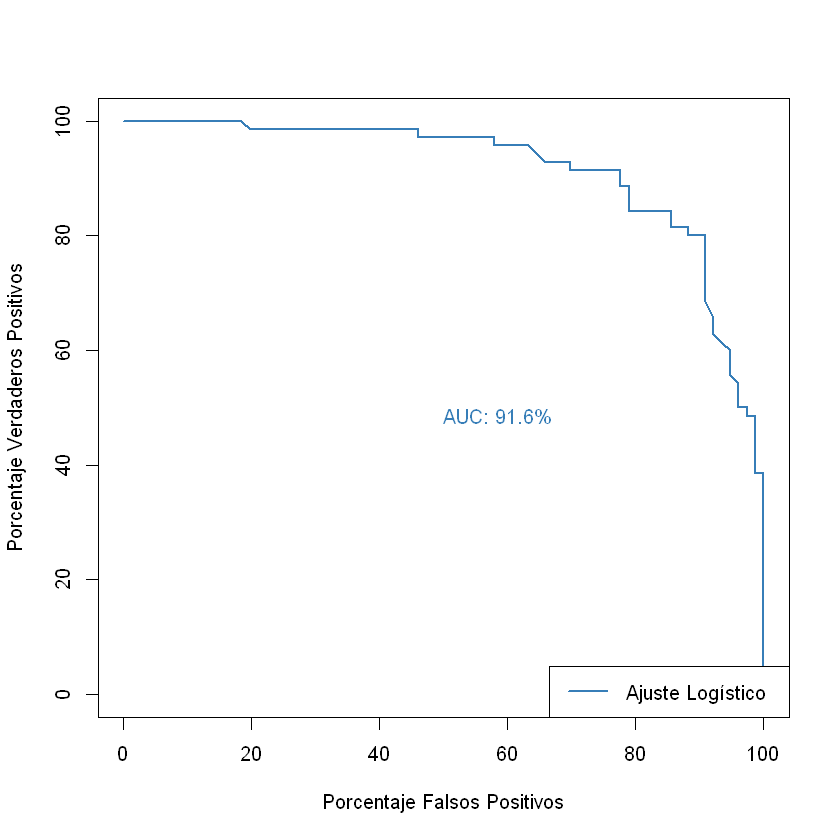

In [91]:
plot(0, 0, 
    type = "n", 
    xlim = c(0, 100), 
    ylim = c(0, 100),
    xlab = "Porcentaje Falsos Positivos", 
    ylab = "Porcentaje Verdaderos Positivos" )

roc_obj <- roc( diabetes$DIABET == 1,
               mod_1$fitted.values,
               plot = TRUE,
               legacy.axes = TRUE,
               add = TRUE,
               print.auc = TRUE,
               percent = TRUE,
               col = "#377eb8",
               lwd = 2 )

legend( "bottomright", 
    legend = c( "Ajuste Logístico" ), 
    col = "#377eb8", 
    lty = 1, lwd = 2 )

print( auc( roc_obj ) )

### Ejemplo: Default

En el siguiente ejemplo se modela la probabilidad de fraude por impago (default) en funci+on del balance de la cuenta bancaria (balance). Los datos están disponibles en la biblioteca ISLR de R.